In [1]:
import os, sys, numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt, collections

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from matplotlib import pyplot as plt
plt.style.use('ggplot')

utils = reload('utils.utils')
np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(88)

d:\python\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Target: 預測會出現哪一隻神奇寶貝(5種)
1. Features dimensions = 200, 時間 天氣 位置 環境等等
2. Label dimensions = 5

## Data Prepare

In [2]:
''' Read input files '''
my_data = np.genfromtxt('./data/pkgo_city66_class5_v1.csv', delimiter=',',skip_header=1)

''' The first column to the 199th column is used as input features '''
X_train = my_data[:,0:200]
X_train = X_train.astype('float32')

''' The 200-th column is the answer '''
y_train = my_data[:,200]
y_train = y_train.astype('int')

''' Convert to one-hot encoding '''
Y_train = tf.keras.utils.to_categorical(y_train,5)

''' Shuffle training data '''
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=100)

''' Split valid data from train data '''
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1)
print("train data shape: {}, valid data shape: {}".format(X_train.shape, X_valid.shape))

train data shape: (1652, 200), valid data shape: (184, 200)


### Data Generator Function: Fetch Data Per Batch

In [3]:
def data_fn(X_train, Y_train, n_batch, shuffle=False):
    """train data iterator"""
    def fn():
        indices = utils.get_minibatches_idx(len(X_train), batch_size=n_batch, shuffle=shuffle)
        for ind in indices:
            yield X_train[ind], Y_train[ind]
    return fn

''' preview training data '''
for data, label in data_fn(X_train, Y_train, n_batch=6, shuffle=False)():
    print("data (shape: {}):\n{}".format(data.shape, data))
    print()
    print("label (shape: {}):\n{}".format(label.shape, label))
    break

data (shape: (6, 200)):
[[ 0.0293 -0.5769  9.     ...  0.      0.      0.    ]
 [ 0.0513 -0.6233  9.     ...  0.      0.      0.    ]
 [ 0.1265 -0.5666  9.     ...  0.      0.      0.    ]
 [ 0.0156 -0.6184  9.     ...  0.      0.      0.    ]
 [-0.7685 -0.6619  9.     ...  0.      0.      0.    ]
 [ 0.326  -0.5496  9.     ...  0.      0.      0.    ]]

label (shape: (6, 5)):
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


## Base Model
1. Extend this base model, training與eval的動作就不用重寫, 只需要注重在graph與hyperparameter的修改

In [4]:
class BaseModel(object):
    def fit(self, train_fn, valid_fn, n_epoch, lr, callback=None):
        """Training
        Arguments:
        ----------
            train_fn: train data batch generator function
            valid_fn: valid data batch generator function
            n_epoch: number of times through all train data
            lr: learning rate
            callback: call on every epoch end
        Returns:
        ----------
            self
        """
        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            # assign learning rate
            sess.run(tf.assign(self.lr, lr))
            
            self.hist = {"tr_loss": [], "tr_acc": [], "vl_loss": [], "vl_acc": []}
            for ep in range(1, n_epoch + 1):
                try:
                    tr_loss, tr_acc, tr_len = 0, 0, 0
                    for i, (tr_x, tr_y) in enumerate(train_fn(), 1):
                        loss, acc, _ = sess.run([self.loss, self.acc, self.train_op], feed_dict=self.feed_dict(tr_x, tr_y, mode="train"))
                        l = len(tr_x)
                        tr_loss += loss * l
                        tr_acc += acc * l
                        tr_len += l

                    vl_loss, vl_acc = self.evaluate(sess, valid_fn)
                    tr_loss, tr_acc = tr_loss / tr_len, tr_acc / tr_len
                    self.hist["tr_loss"].append(tr_loss)
                    self.hist["tr_acc"].append(tr_acc)
                    self.hist["vl_loss"].append(vl_loss)
                    self.hist["vl_acc"].append(vl_acc)
                    if callback is not None:
                        callback(self)
                    print("\r{}/{}.  train loss: {:.3f}, valid loss: {:.3f}, train acc: {:.3f}, valid acc: {:.3f}".\
                          format(ep, n_epoch, tr_loss, vl_loss, tr_acc, vl_acc), end="")
                except StopIteration as si: 
                    print(si)
                    break
        return self

    def evaluate(self, sess, valid_fn):
        """算出valid data的所有資料loss, accuracy"""
        vl_loss, vl_acc, total = 0, 0, 0
        for vl_x, vl_y in valid_fn():
            loss, acc = sess.run([self.loss, self.acc], feed_dict=self.feed_dict(vl_x, vl_y, mode="eval"))
            l = len(vl_x)
            vl_loss += loss * l
            vl_acc += acc * l
            total += l
        return vl_loss / total, vl_acc / total
    
    def feed_dict(self, x, y, mode="train"):
        """建立餵給tensorflow的dictionary"""
        assert mode in ("train", "eval", "infer"), "mode not in (train, eval, infer)"
        ret = {self.inputs: x, self.labels: y}
        if mode == "train":
            ret[self.is_train] = True
        else:
            ret[self.is_train] = False
        return ret
    
    def plot(self):
        """Loss and Accuracy plot"""
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(self.hist["tr_loss"], label='Train', marker="o", markersize=5)
        plt.plot(self.hist["vl_loss"], label='Valid', marker="o", markersize=5)
        plt.title('Loss')
        plt.legend(loc='upper left')
        plt.subplot(122)
        plt.plot(self.hist["tr_acc"], label='Train', marker="o", markersize=5)
        plt.plot(self.hist["vl_acc"], label='Valid', marker="o", markersize=5)
        plt.title('Accuracy')
        plt.show()

## Classification With MSE
```
+ learning_rate: 0.01 
+ loss function: mean square error
+ optimizer: 基本款 => GradientDescentOptimizer
+ activation function: sigmoid
```

mean square error model!
30/30.  train loss: 0.134, valid loss: 0.133, train acc: 0.516, valid acc: 0.522

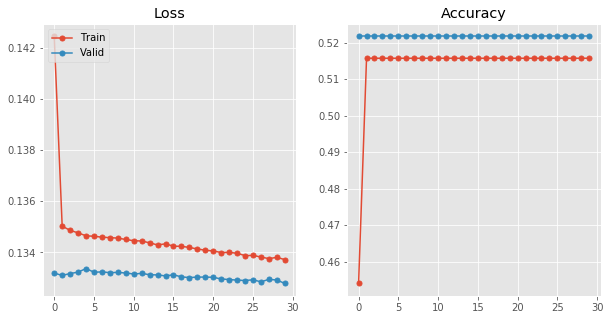

In [15]:
# 調整learning rate
learning_rate = 0.01
# 調整每個batch資料數量
n_batch = 16
# 調整epoch數量, 一個epoch代表跑完一次train data
n_epoch = 30

class ModelMSE(BaseModel):
    def __init__(self):
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)
                
            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.sigmoid, name="dnn1")
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.sigmoid, name="dnn2")
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, name="dnn3")
                self.pred = tf.nn.softmax(nets, name="pred")
                
            with tf.variable_scope("loss"):
                # 使用 mean squared error loss function
                self.loss = tf.losses.mean_squared_error(labels=self.labels, predictions=self.pred)
            
            with tf.variable_scope("eval"):
                # 計算 accuracy
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )
                
            with tf.variable_scope("train"):
                self.train_op = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)
        self.graph = graph
        
print("mean square error model!")
tf.reset_default_graph()
model_mse = ModelMSE()
model_mse.fit(data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)
model_mse.plot()

## Classification With Cross Entropy
```
+ learning_rate: 0.01 
+ loss function: softmax cross entropy
+ optimizer: 基本款 => GradientDescentOptimizer
+ activation function: sigmoid
```

cross entropy model!
30/30.  train loss: 1.223, valid loss: 1.277, train acc: 0.585, valid acc: 0.543

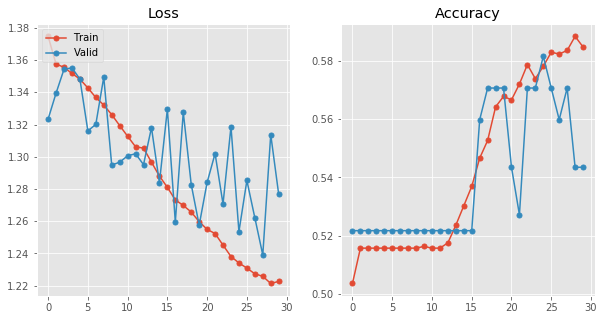

In [16]:
# 調整learning rate
learning_rate = 0.01
# 調整每個batch資料數量
n_batch = 16
# 調整epoch數量, 一個epoch代表跑完一次train data
n_epoch = 30

class ModelCE(BaseModel):
    def __init__(self):
        # super(Model, self).__init__()
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)

            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.sigmoid, name="dnn1")
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.sigmoid, name="dnn2")
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, name="dnn3")

            with tf.variable_scope("loss"):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=nets))
                
            with tf.variable_scope("eval"):
                self.pred = tf.nn.softmax(nets, name="pred")
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )

            with tf.variable_scope("train"):
                self.train_op = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)
                
        self.graph = graph
        
print("cross entropy model!")
tf.reset_default_graph()
model_ce = ModelCE()
model_ce.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)
model_ce.plot()

## Try Learning Rate!
```
+ learning_rate: 0.1, 0.01, 0.001
+ loss function: softmax cross entropy
+ optimizer: 基本款 => GradientDescentOptimizer
+ activation function: sigmoid
```

Try learning rate!
30/30.  train loss: 1.177, valid loss: 1.253, train acc: 0.591, valid acc: 0.576  learning rate: 0.1 done !
30/30.  train loss: 1.212, valid loss: 1.247, train acc: 0.584, valid acc: 0.571  learning rate: 0.01 done !
30/30.  train loss: 1.336, valid loss: 1.322, train acc: 0.516, valid acc: 0.522  learning rate: 0.001 done !


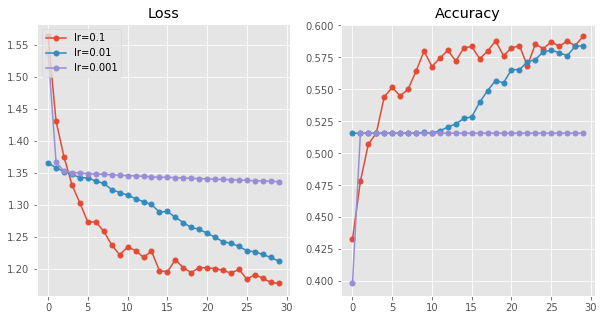

In [13]:
# 調整learning rate
learning_rate = [0.1, 0.01, 0.001]
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量, 一個epoch代表跑完一次train data
n_epoch = 30
        
print("Try learning rate!")
hist = collections.OrderedDict()
tf.reset_default_graph()
model_ce = ModelCE()
for lr in learning_rate:
    model_ce.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr)
    hist[str(lr)] = model_ce.hist
    print("  learning rate: {} done !".format(lr))

plt.figure(figsize=(10, 5))
plt.subplot(121)
for lr in learning_rate:
    plt.plot(hist[str(lr)]["tr_loss"], label='lr={}'.format(lr), marker="o", markersize=5)
plt.title('Loss')
plt.legend(loc='upper left')

plt.subplot(122)
for lr in learning_rate:
    plt.plot(hist[str(lr)]["tr_acc"], label='lr={}'.format(lr), marker="o", markersize=5)
plt.title('Accuracy')
plt.show()

## Try Activation Function
```
+ learning_rate: 0.01
+ loss function: softmax cross entropy
+ optimizer: 基本款 => GradientDescentOptimizer
+ activation function: sigmoid or softplus or relu
```

model with sigmoid activation function!
30/30.  train loss: 1.211, valid loss: 1.222, train acc: 0.583, valid acc: 0.571

model with relu activation function!
30/30.  train loss: 1.049, valid loss: 1.482, train acc: 0.625, valid acc: 0.522

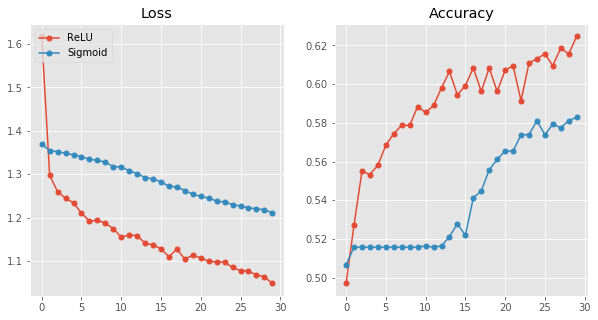

In [17]:
# 調整learning rate
learning_rate = 0.01
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量, 一個epoch代表跑完一次train data
n_epoch = 30

class ModelSigmoid(BaseModel):
    def __init__(self):
        # super(Model, self).__init__()
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)

            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.sigmoid, name="dnn1")
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.sigmoid, name="dnn2")
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, name="dnn3")

            with tf.variable_scope("loss"):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=nets))
                
            with tf.variable_scope("eval"):
                self.pred = tf.nn.softmax(nets, name="pred")
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )

            with tf.variable_scope("train"):
                self.train_op = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)
                
        self.graph = graph

class ModelReLU(BaseModel):
    def __init__(self):
        # super(Model, self).__init__()
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)

            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.relu, name="dnn1")
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.relu, name="dnn2")
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, name="dnn3")

            with tf.variable_scope("loss"):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=nets))
                
            with tf.variable_scope("eval"):
                self.pred = tf.nn.softmax(nets, name="pred")
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )

            with tf.variable_scope("train"):
                self.train_op = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss)
                
        self.graph = graph
        
print("model with sigmoid activation function!")
tf.reset_default_graph()
model_sm = ModelSigmoid()
model_sm.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)

print("\n\nmodel with relu activation function!")
tf.reset_default_graph()
model_relu = ModelReLU()
model_relu.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)

hist = {"sigmoid": model_sm.hist, "relu": model_relu.hist}
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist["relu"]["tr_loss"], label='ReLU', marker="o", markersize=5)
plt.plot(hist["sigmoid"]["tr_loss"], label='Sigmoid', marker="o", markersize=5)
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(hist["relu"]["tr_acc"], label='ReLU', marker="o", markersize=5)
plt.plot(hist["sigmoid"]["tr_acc"], label='Sigmoid', marker="o", markersize=5)
plt.title('Accuracy')
plt.show()
# 30/30.  train loss: 1.082, valid loss: 1.521, train acc: 0.618, valid acc: 0.484

## Try Different Optimizer
```
+ learning_rate: 0.01
+ loss function: softmax cross entropy
+ optimizer: GradientDescentOptimizer or AdamOptimizer
+ activation function: relu
```

model with Adam optimizer!
30/30.  train loss: 0.933, valid loss: 0.987, train acc: 0.666, valid acc: 0.663

model with SGD optimizer!
30/30.  train loss: 1.052, valid loss: 1.221, train acc: 0.627, valid acc: 0.560

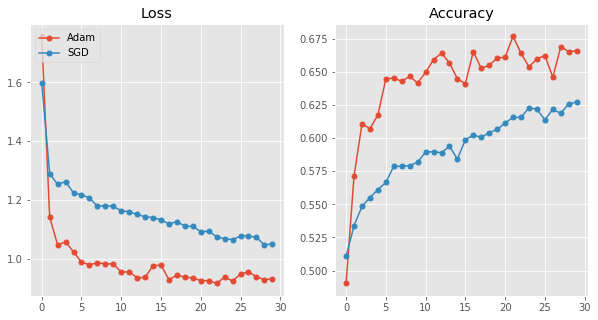

In [19]:
# 調整learning rate
learning_rate = 0.01
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量, 一個epoch代表跑完一次train data
n_epoch = 30

class ModelAdam(BaseModel):
    def __init__(self):
        # super(Model, self).__init__()
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)

            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.relu, name="dnn1")
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.relu, name="dnn2")
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, name="dnn3")

            with tf.variable_scope("loss"):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=nets))
                
            with tf.variable_scope("eval"):
                self.pred = tf.nn.softmax(nets, name="pred")
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )

            with tf.variable_scope("train"):
                # optimizer改成AdamOptimizer
                self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        self.graph = graph
        
print("model with Adam optimizer!")
tf.reset_default_graph()
model_adam = ModelAdam()
model_adam.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)        
        
print("\n\nmodel with SGD optimizer!")
tf.reset_default_graph()
model_relu = ModelReLU()
model_relu.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)

hist = {"sgd": model_relu.hist, "adam": model_adam.hist}
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist["adam"]["tr_loss"], label='Adam', marker="o", markersize=5)
plt.plot(hist["sgd"]["tr_loss"], label='SGD', marker="o", markersize=5)
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(hist["adam"]["tr_acc"], label='Adam', marker="o", markersize=5)
plt.plot(hist["sgd"]["tr_acc"], label='SGD', marker="o", markersize=5)
plt.title('Accuracy')
plt.show()

## Overfitting Check
```
+ learning_rate: 0.001
+ loss function: softmax cross entropy
+ optimizer: AdamOptimizer
+ activation function: relu
+ number of train epoch: 30 to 50 => 故意把training次數增加, 觀察是否有overfitting狀況發生
```

model with Adam optimizer and train 50 epochs !
50/50.  train loss: 0.192, valid loss: 1.533, train acc: 0.936, valid acc: 0.647

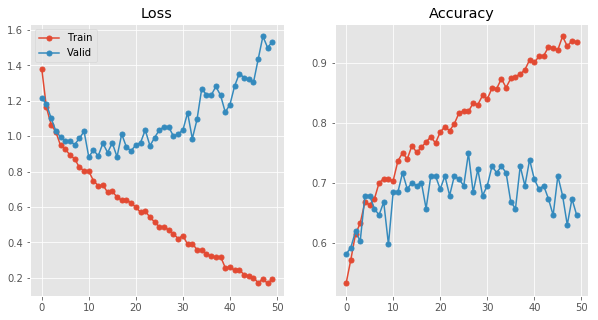

In [20]:
# 調整learning rate
learning_rate = 0.001
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量為50
n_epoch = 50

print("model with Adam optimizer and train 50 epochs !")
tf.reset_default_graph()
model_adam = ModelAdam()
model_adam.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)
model_adam.plot()

## Observations
1. 觀察Loss and Accuracy的曲線變化, Training部份越來越完美, 可是Valid部分已經開始崩壞, 這正是Overfitting的象徵
<br/>
<br/>
<br/>

## Solve Overfitting: EarlyStopping
### 檢查Valid Loss變化, 若發現Loss持續增加超過一定Threshold, 則停止Training
```
+ learning_rate: 0.001
+ loss function: softmax cross entropy
+ optimizer: AdamOptimizer
+ activation function: relu
+ number of train epoch: 50
```

23/50.  train loss: 0.590, valid loss: 0.956, train acc: 0.794, valid acc: 0.690
Early Stopping, valid loss keep increasing for 5 times ! lowest loss is 0.857 !


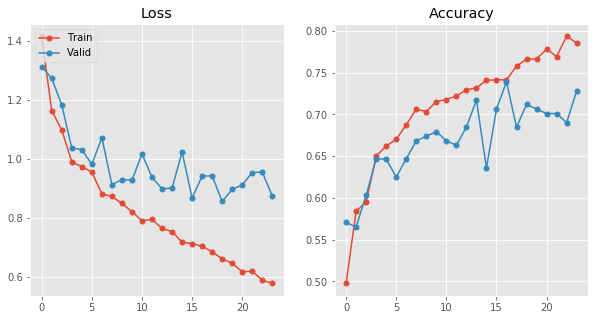

In [21]:
# 調整learning rate
learning_rate = 0.001
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量為50
n_epoch = 50

class EarlyStopping(object):
    """若valid loss持續增加超過一定次數則raise StopIteration"""
    def __init__(self, thres):
        self.patient = 0
        self.min_loss = 1e7
        self.thres = thres
        
    def __call__(self, model):
        last_vl_loss = model.hist["vl_loss"][-1]
        if self.min_loss > last_vl_loss:
            self.patient = 0
            self.min_loss = last_vl_loss
        else:
            self.patient += 1
        if self.patient >= self.thres:
            raise StopIteration("\nEarly Stopping, valid loss keep increasing for {} times ! "
                                "lowest loss is {:.3f} !"
                                .format(self.patient, self.min_loss))
            
tf.reset_default_graph()
model_adam = ModelAdam()
model_adam.fit(data_fn(X_train, Y_train, n_batch, shuffle=True), 
               data_fn(X_valid, Y_valid, n_batch, shuffle=False), 
               n_epoch, 
               lr=learning_rate,
               callback=EarlyStopping(thres=5))
model_adam.plot()

## Solve Overfitting: Add Regularizer Term to Loss Function
```
+ learning_rate: 0.001
+ loss function: softmax cross entropy
+ optimizer: AdamOptimizer
+ activation function: relu
+ number of train epoch: 50

+ >>> add l2 regularizer term to each hidden layers with scale 0.01
```

50/50.  train loss: 0.944, valid loss: 1.086, train acc: 0.720, valid acc: 0.707

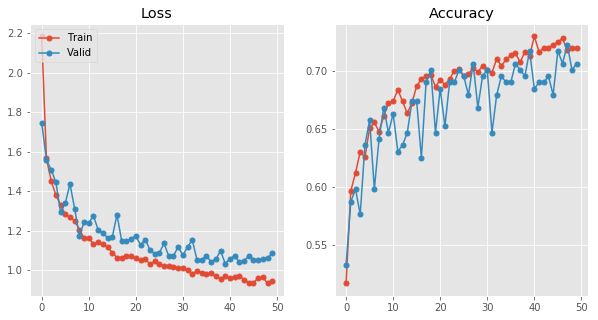

In [23]:
# 調整learning rate
learning_rate = 0.001
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量為50
n_epoch = 50

class ModelAdamRegularized(BaseModel):
    def __init__(self):
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)
            
            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                # 在各hidden layers加上regularizer term, scale = 0.01
                reg_scale = 0.01
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.relu,
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(reg_scale), name="dnn1")
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.relu, 
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(reg_scale), name="dnn2")
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, 
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(reg_scale), name="dnn3")

            with tf.variable_scope("loss"):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=nets))
                # 在Loss function後加上正規項
                for reg_term in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES):
                    self.loss += reg_term
                
            with tf.variable_scope("eval"):
                self.pred = tf.nn.softmax(nets, name="pred")
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )

            with tf.variable_scope("train"):
                self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        self.graph = graph
        
tf.reset_default_graph()
model_adam_reg = ModelAdamRegularized()
model_adam_reg.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)
model_adam_reg.plot()

## Solve Overfitting: Dropout
```
+ learning_rate: 0.001
+ loss function: softmax cross entropy
+ optimizer: AdamOptimizer
+ activation function: relu

+ number of train epoch: 100
>>> Dropout會讓training速度變慢, 增加epoch次數讓分數更好!
```

100/100.  train loss: 0.762, valid loss: 0.877, train acc: 0.718, valid acc: 0.745

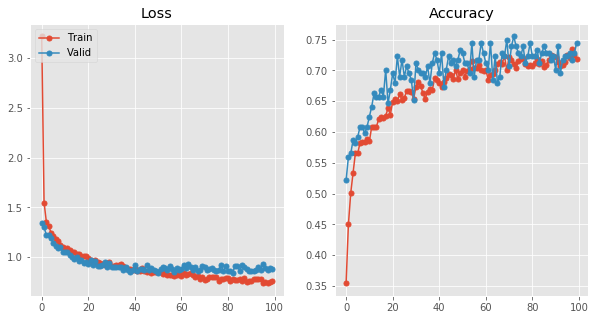

In [24]:
# 調整learning rate
learning_rate = 0.001
# 調整每個batch資料數量
n_batch = 16 
# 調整epoch數量為100
n_epoch = 100

class ModelAdamDropout(BaseModel):
    def __init__(self):
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None, 200], name="inputs")
                self.labels = tf.placeholder(tf.float32, [None, 5], name="labels")
                self.is_train = tf.placeholder(tf.bool, None, name="is_train")
                # learning rate init value = 0.1
                self.lr = tf.Variable(0.1, trainable=False)
            
            init_fn = tf.glorot_normal_initializer()
            with tf.variable_scope("dnn"):
                # 在各hidden layers後加上dropout function
                # drop rate = 0.5, 每次隨機drop 50%的neurons
                drop_rate = 0.5
                nets = tf.layers.dense(self.inputs, 128, kernel_initializer=init_fn, activation=tf.nn.relu, name="dnn1")
                nets = tf.layers.dropout(nets, drop_rate, training=self.is_train)
                nets = tf.layers.dense(nets, 256, kernel_initializer=init_fn, activation=tf.nn.relu, name="dnn2")
                nets = tf.layers.dropout(nets, drop_rate, training=self.is_train)
                nets = tf.layers.dense(nets, 5, kernel_initializer=init_fn, activation=None, name="dnn3")

            with tf.variable_scope("loss"):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=nets))
                
            with tf.variable_scope("eval"):
                self.pred = tf.nn.softmax(nets, name="pred")
                self.acc = tf.reduce_mean( tf.to_float(tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.labels, 1))) )

            with tf.variable_scope("train"):
                # optimizer改成AdamOptimizer
                self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        self.graph = graph
        
tf.reset_default_graph()
model_adam_dp = ModelAdamDropout()
model_adam_dp.fit( data_fn(X_train, Y_train, n_batch, shuffle=True), data_fn(X_valid, Y_valid, n_batch, shuffle=False), n_epoch, lr=learning_rate)
model_adam_dp.plot()

## Observations
1. 觀察Loss and Accuracy的曲線變化, Valid Loss曲線在50 epochs之後已經下降變慢, 但並沒有遽增
2. Accuracy的部分Valid data也接近75%了
<br/>
<br/>
<br/>